In [1]:
from sqlalchemy import Column, Integer, MetaData, Table, create_engine, String
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.sql import select
from sqlalchemy import func

In [2]:
engine = create_engine('postgres://douglas@postgis:5432/AQI', client_encoding='utf8')
Session = sessionmaker(bind=engine)
session = Session()

metadata = MetaData()
metadata.reflect(engine, only=['locs_airlocation', 'locs_airmeasurement'])
Base = automap_base(metadata=metadata)
Base.prepare()

AirLocation, AirMeasurement = Base.classes.locs_airlocation, Base.classes.locs_airmeasurement

/opt/conda/lib/python3.5/site-packages/sqlalchemy/dialects/postgresql/base.py:2503: SAWarning: Did not recognize type 'geometry' of column 'coordinates'
  (attype, name))


In [19]:
# Select some airlocation with bad aqi
s = select([AirLocation]).where(AirLocation.aqi > 100)
some_airlocation_id = session.execute(s).scalar()
s = select([AirLocation]).where(AirLocation.id == some_airlocation_id)
some_airlocation = session.execute(s).first()
print("{}, {}".format(some_airlocation.short_name, some_airlocation.en_country_name))
s = select([func.count(AirMeasurement.id)]).where(
    AirMeasurement.airlocation_id == some_airlocation_id
).where(
    AirMeasurement.aqi != None
)
some_airlocation_measurement_count = session.execute(s).first()[0]
print("{} AQI measurements for this city".format(some_airlocation_measurement_count))

Mudanjiang, China
37663 AQI measurements for this city


In [44]:
# Collect the measurements for that AirLocation into a
# numpy array like [(min of day, day of year, day of week, day of month, aqi)]
s = select([AirMeasurement.id, AirMeasurement.measurement_datetime, AirMeasurement.aqi]).where(
    AirMeasurement.airlocation_id == 48
).where(
    AirMeasurement.aqi != None
)

import numpy as np
import pandas as pd
measurements = pd.read_sql(s, engine)

In [45]:
def get_normalized_time_inputs(dt):
    return [
        # minute of day
        ((dt.time().hour * 60) + dt.time().minute) / 1440,
        # day of the year 
        dt.timetuple().tm_yday / 365,
        # day of the week, from 0 to 6
        dt.date().weekday() / 6,
        # day of the month
        dt.date().day / 31,
    ]
measurements['minute_of_day'], \
measurements['day_of_year'], \
measurements['day_of_week'], \
measurements['day_of_month'] = \
    zip(*measurements["measurement_datetime"].map(get_normalized_time_inputs))

In [46]:
# Generate the baseline predictions
measurements['baseline_pred_aqi'] = measurements['aqi']
measurements['baseline_pred_aqi'] = measurements['baseline_pred_aqi'][-1:] + measurements['baseline_pred_aqi'][:-1]

In [47]:
# Perform test-train split
from sklearn.cross_validation import train_test_split
import itertools
feature_columns = ['minute_of_day', 'day_of_year', 'day_of_week', 'day_of_month']
# keep the id and baseline through the split to graph results later
x_all = measurements[list(itertools.chain(feature_columns, ['id', 'baseline_pred_aqi']))]
y_all = measurements['aqi']
y_all.columns = ['actual_aqi']
num_train = int(some_airlocation_measurement_count * 0.75)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, train_size=num_train)

In [49]:
# Input to SVM model
import time

def train_classifier(clf, x_train, y_train):
    print("Training {}...".format(clf.__class__.__name__))
    start = time.time()
    clf.fit(x_train[feature_columns], y_train)
    end = time.time()
    print("Done!\nTraining time (secs): {:.3f}".format(end - start))

from sklearn import svm
clf = svm.SVC()
train_classifier(clf, x_train, y_train)

Training SVC...


Done!
Training time (secs): 53.033


In [55]:
from sklearn.metrics import f1_score

def predict_labels(clf, features, target):
    print("Predicting labels using {}...".format(clf.__class__.__name__))
    start = time.time()
    y_pred = clf.predict(features[feature_columns])
    end = time.time()
    print("Done!\nPrediction time (secs): {:.3f}".format(end - start))
    return y_pred, f1_score(target.values, y_pred)

y_train_pred, train_f1_score = predict_labels(clf, x_train, y_train)
print("F1 score for training set: {}".format(train_f1_score))
y_test_pred, test_f1_score = predict_labels(clf, x_test, y_test)
print("F1 score for test set: {}".format(test_f1_score))

Predicting labels using SVC...


Done!
Prediction time (secs): 265.070
F1 score for training set: 0.034882349579657
Predicting labels using SVC...


/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Done!
Prediction time (secs): 89.857
F1 score for test set: 0.03646475042273082


/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


[0.0, 130000000.0, 0.0, 250.0]

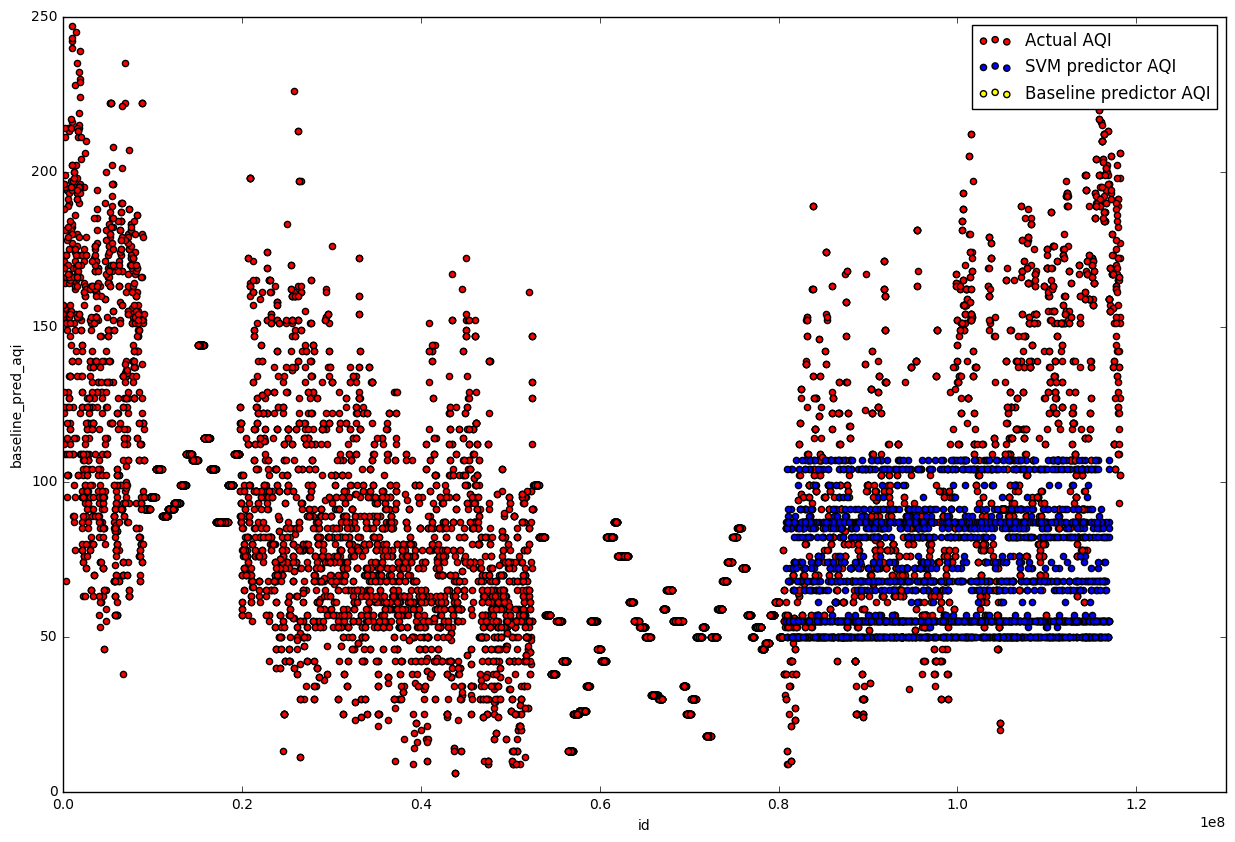

In [77]:
# Gather all the predictions together to plot
y_test_pred_df = pd.DataFrame({'pred_aqi': y_test_pred})

test_results = x_test[['id', 'baseline_pred_aqi']].join(y_test_pred_df)
test_results = test_results.join(y_test)

import matplotlib.pyplot as plt
aqi_graph = test_results.plot.scatter(x='id', y='aqi', label="Actual AQI", color="Red")
test_results.plot.scatter(x='id', y='pred_aqi', label="SVM predictor AQI", ax=aqi_graph, color="Blue")
test_results.plot.scatter(x='id', y='baseline_pred_aqi', label="Baseline predictor AQI", ax=aqi_graph, color="Yellow")
hf = aqi_graph.figure
hf.set_size_inches((15, 10), forward=True)
aqi_graph.axis([0.0, 130000000.0, 0.0, 250.0])

[80000000.0, 90000000.0, 0.0, 250.0]

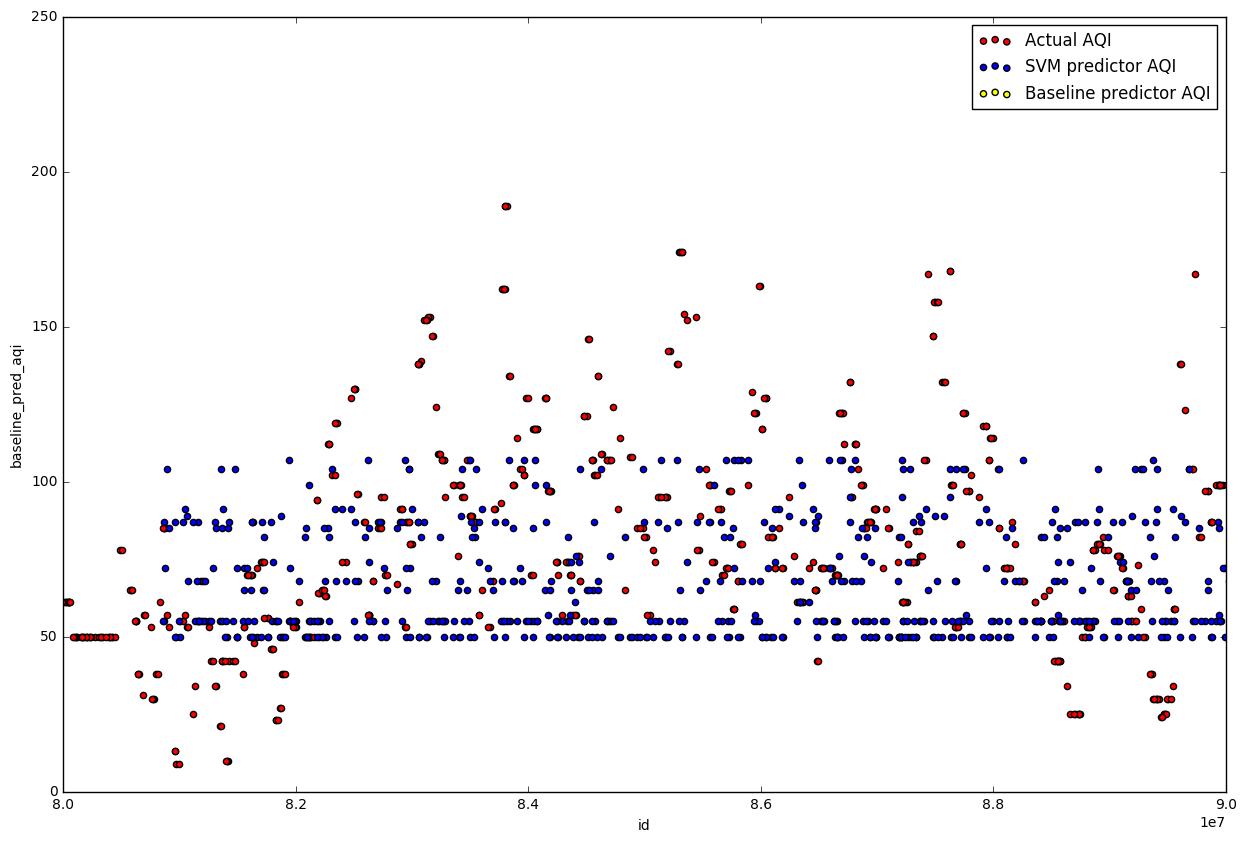

In [78]:
aqi_graph = test_results.plot.scatter(x='id', y='aqi', label="Actual AQI", color="Red")
test_results.plot.scatter(x='id', y='pred_aqi', label="SVM predictor AQI", ax=aqi_graph, color="Blue")
test_results.plot.scatter(x='id', y='baseline_pred_aqi', label="Baseline predictor AQI", ax=aqi_graph, color="Yellow")
hf = aqi_graph.figure
hf.set_size_inches((15, 10), forward=True)
aqi_graph.axis([80000000.0, 90000000.0, 0.0, 250.0])

In [59]:
# produce baseline
# visualize actual, errors, and baseline in scatter plot
# compare error of baseline to predicted